#### Library import

In [78]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [79]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [80]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [81]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14533977236520359369
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9405912484099421179
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [82]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [83]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [84]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [85]:
As = data
Cd = data
Ni = data

In [86]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [87]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [88]:
import smogn

In [89]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   0%|          | 1/248 [00:00<00:25,  9.52it/s]

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 168.02it/s]


In [90]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(2183, 16)
(2151, 16)
(2183, 16)


#### Eliminate outlier and train / test split

In [91]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [92]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [93]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [94]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [95]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1732, 15)
(1762, 15)
(2078, 15)


StandardScaler

In [96]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)\n\nAs_X_train = scaler.fit_transform(As_X_train)\nAs_X_test = scaler.fit_transform(As_X_test)\n\nCd_X_train = scaler.fit_transform(Cd_X_train)\nCd_X_test = scaler.fit_transform(Cd_X_test)\n\nNi_X_train = scaler.fit_transform(Ni_X_train)\nNi_X_test = scaler.fit_transform(Ni_X_test) '

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

MinMaxScaler

In [98]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [99]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1385, 15)
(1409, 15)
(1662, 15)


#### 10-Fold Crossvalidation

In [100]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [101]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [102]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [103]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-23 21:48:31,408] A new study created in memory with name: rf_parameter_opt
[I 2023-08-23 21:48:32,500] Trial 0 finished with value: 0.3605496063755983 and parameters: {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 16, 'min_samples_split': 20}. Best is trial 0 with value: 0.3605496063755983.
[I 2023-08-23 21:48:33,384] Trial 1 finished with value: 0.3615091362131662 and parameters: {'n_estimators': 63, 'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 13}. Best is trial 1 with value: 0.3615091362131662.
[I 2023-08-23 21:48:34,312] Trial 2 finished with value: 0.36117765307939 and parameters: {'n_estimators': 66, 'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 16}. Best is trial 1 with value: 0.3615091362131662.
[I 2023-08-23 21:48:37,074] Trial 3 finished with value: 0.5485592218245868 and parameters: {'n_estimators': 96, 'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 2}. Best is trial 3 with value: 0.5485592218245868.
[I 2023-0

Best r2:  0.6097576780555596
Best trial: {'n_estimators': 84, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}


In [104]:
optuna.visualization.plot_parallel_coordinate(study)

In [105]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 84, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}


In [106]:
study.best_trial.params["n_estimators"]

84

In [107]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=84, random_state=42)

In [108]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [109]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [110]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.28088286844456933
Test RMSE:  0.5379500884610775


In [111]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.8839917521058941
Test R2:  0.6174973823585634


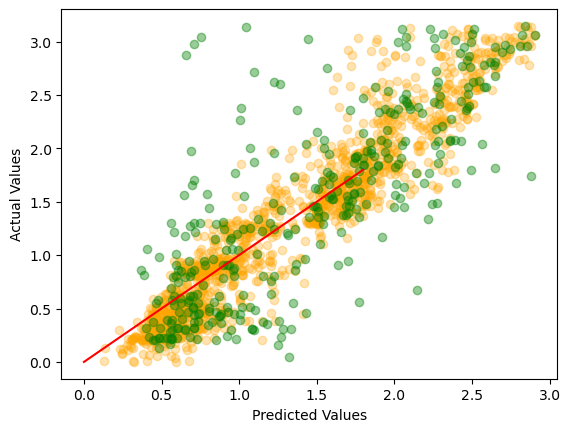

In [112]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [113]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-23 21:52:57,638] A new study created in memory with name: rf_parameter_opt
[I 2023-08-23 21:52:58,603] Trial 0 finished with value: 0.6097986387960086 and parameters: {'n_estimators': 28, 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 19}. Best is trial 0 with value: 0.6097986387960086.
[I 2023-08-23 21:52:59,396] Trial 1 finished with value: 0.2426300544473298 and parameters: {'n_estimators': 82, 'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 2}. Best is trial 0 with value: 0.6097986387960086.
[I 2023-08-23 21:53:01,616] Trial 2 finished with value: 0.5823253065763121 and parameters: {'n_estimators': 68, 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 16}. Best is trial 0 with value: 0.6097986387960086.
[I 2023-08-23 21:53:02,302] Trial 3 finished with value: 0.38404809600495077 and parameters: {'n_estimators': 48, 'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 6}. Best is trial 0 with value: 0.6097986387960086.
[I 2023-

Best r2:  0.6829058177341895
Best trial: {'n_estimators': 94, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [114]:
optuna.visualization.plot_parallel_coordinate(study)

In [115]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 94, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


94

In [116]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, n_estimators=94, random_state=42)

In [117]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [118]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.0636358641562647
Test RMSE:  0.1277047664039181


In [119]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9106367072845807
Test R2:  0.6962456007959335


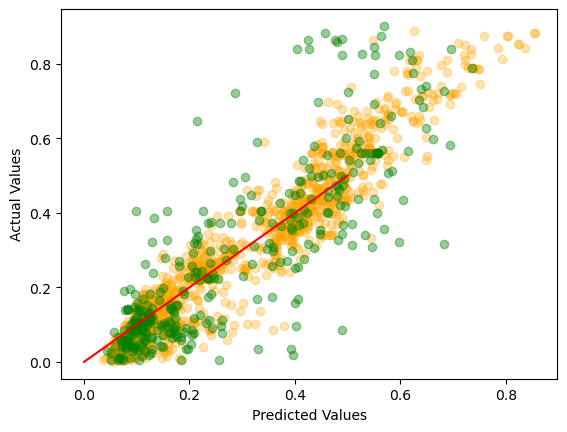

In [120]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [121]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-23 21:58:10,589] A new study created in memory with name: rf_parameter_opt
[I 2023-08-23 21:58:12,358] Trial 0 finished with value: 0.550418533063507 and parameters: {'n_estimators': 46, 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 18}. Best is trial 0 with value: 0.550418533063507.
[I 2023-08-23 21:58:13,296] Trial 1 finished with value: 0.16681189262971033 and parameters: {'n_estimators': 91, 'max_depth': 1, 'min_samples_leaf': 18, 'min_samples_split': 17}. Best is trial 0 with value: 0.550418533063507.
[I 2023-08-23 21:58:15,751] Trial 2 finished with value: 0.4808707541082969 and parameters: {'n_estimators': 79, 'max_depth': 5, 'min_samples_leaf': 12, 'min_samples_split': 7}. Best is trial 0 with value: 0.550418533063507.
[I 2023-08-23 21:58:16,351] Trial 3 finished with value: 0.16497810549032307 and parameters: {'n_estimators': 57, 'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 15}. Best is trial 0 with value: 0.550418533063507.
[I 2023-08

Best r2:  0.6829410105479614
Best trial: {'n_estimators': 30, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [122]:
optuna.visualization.plot_parallel_coordinate(study)

In [123]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 30, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


30

In [124]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, n_estimators=30, random_state=42)

In [125]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [126]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.34274203542048376
Test RMSE:  0.6198802947817844


In [127]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9212627958773654
Test R2:  0.7251089954705117


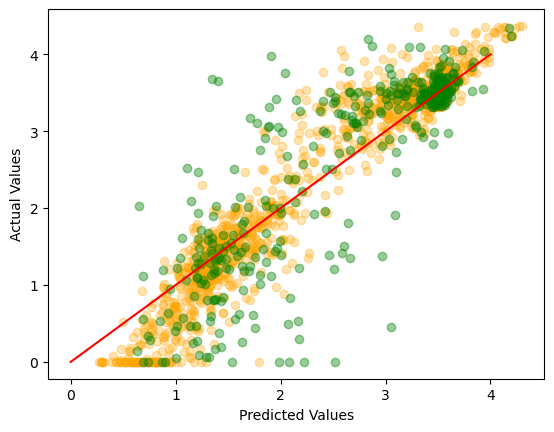

In [128]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()